# Dataset SCIA
Registrazione delle misure recuperate da SCIA

In [124]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(tsibble, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(sf, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(assertr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source("notebooks/integrazioni_regionali/nb_tools/state_avail.R")
source("notebooks/integrazioni_regionali/nb_tools/pairing_procedure.R")
source("src/load/load.R")
source("src/analysis/data/clim_availability.R")
source("src/analysis/data/quality_check.R")
source("src/pairing/analysis.R")
source("src/pairing/matching.R")
source("src/pairing/plots.R")
source("src/pairing/combining.R")
source("src/pairing/displaying.R")
source("src/plot/plot_helpers.R")
source("src/database/write.R")
source("src/database/open.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")


In [2]:
dataset_id <- "SCIA"


## Caricamento da frammenti

In [3]:
ds <- open.dataset("SCIA", "data")
meta <- open.dataset("SCIA", "metadata")


## Metadati
Produco le tabelle dei metadati del dataset e delle stazioni. Controllo con `assertr` e `tsibble` la consistenza delle tabelle.

### Dataset
| dataset_id | entity | reference | 
|------------|--------|-----------|
| utf8()     | utf8() | utf8()    |
| pkey       | obs    | obs       |

### Stazioni
| station_id | station_name | network | state | geometa | dataset_id | original_id |
|------------|--------------|---------|-------|---------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|         | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   |         | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "additional_meta" alla quale puntare con un riferimento

### Serie
| series_id | station_id  | variable | qc_step | merged_from |
|-----------|-------------|----------|---------|-------------|



In [25]:
meta |>
    rename(station_name = anagrafica, network = rete, original_id = identifier) |>
    select(-variable) |>
    mutate(original_id = cast(original_id, utf8())) |>
    collect() |>
    distinct(original_id, .keep_all = TRUE) |>
    write_station_metadata(dataset_id)


In [4]:
stations_table <- read_station_metadata(dataset_id) |>
    left_join(read_station_extra_metadata(dataset_id)) |>
    collect()


In [60]:
bind_rows(T_MIN = stations_table, T_MAX = stations_table, .id = "variable") |>
    mutate(qc_step = "raw", merged_from = list(NA_character_)) |>
    write_series_metadata(dataset_id)


In [5]:
series_table <- read_series_metadata(dataset_id)


## Dati
Produco la tabella delle misure. Il formato è row-records:

|series_id|date|value|merged|
|---------|----|-----|------|
|utf8()|date()|float()|bool()|
| fkey    |obs | obs | obs  |

Note:
- `merged` indica se il valore in riga è risultato di un merge. Le caratteristiche del merge sono riportate nella tabella delle stazioni.

Effettuare controllo qualità

In [6]:
ser_stat_tab <- series_table |>
    select(series_id, variable, station_id) |>
    left_join(stations_table |>
        select(station_id, original_id), by = "station_id") |>
    collect()


In [85]:
ds |>
    arrange(identifier, variable, date) |>
    gross_errors_check(value) |>
    collect() |>
    as_tsibble(key = c(identifier, variable), index = date) |>
    repeated_values_check() |>
    as_tibble() |>
    # filter(!qc_gross & !qc_repeated) |>
    select(!starts_with("qc")) |>
    mutate(identifier = as.character(identifier)) |>
    left_join(
        ser_stat_tab,
        by = join_by(identifier == original_id, variable)
    ) |>
    mutate(merged = FALSE) |>
    write_data(dataset_id)


In [146]:
data <- open_data(dataset_id) |>
    collect()


In [152]:
data |> group_by(series_id) |> summarise(valid_days = sum(!is.na(value)), first_date = min(date, na.rm = TRUE), last_date = max(date, na.rm = TRUE)) |> write_parquet(file.path("db", "metadata", "extra", "SCIA_series_stats_from_2000.parquet"))

Eseguo un check delle serie con tanti valori ripetuti e con solo valori interi: cene sono un certo numero. Tante sono in comune.

In [11]:
series_table.insights <- data |>
        group_by(series_id) |>
        summarise(qc_repeated_fraction = repeated_fraction_check(value), qc_integer_fraction = integers_fraction_check(value)) |>
        mutate(series_id = as.character(series_id))
series_table.insights |> write_parquet(file.path("db", "metadata", "series", "SCIA.repeated-integers.parquet"))


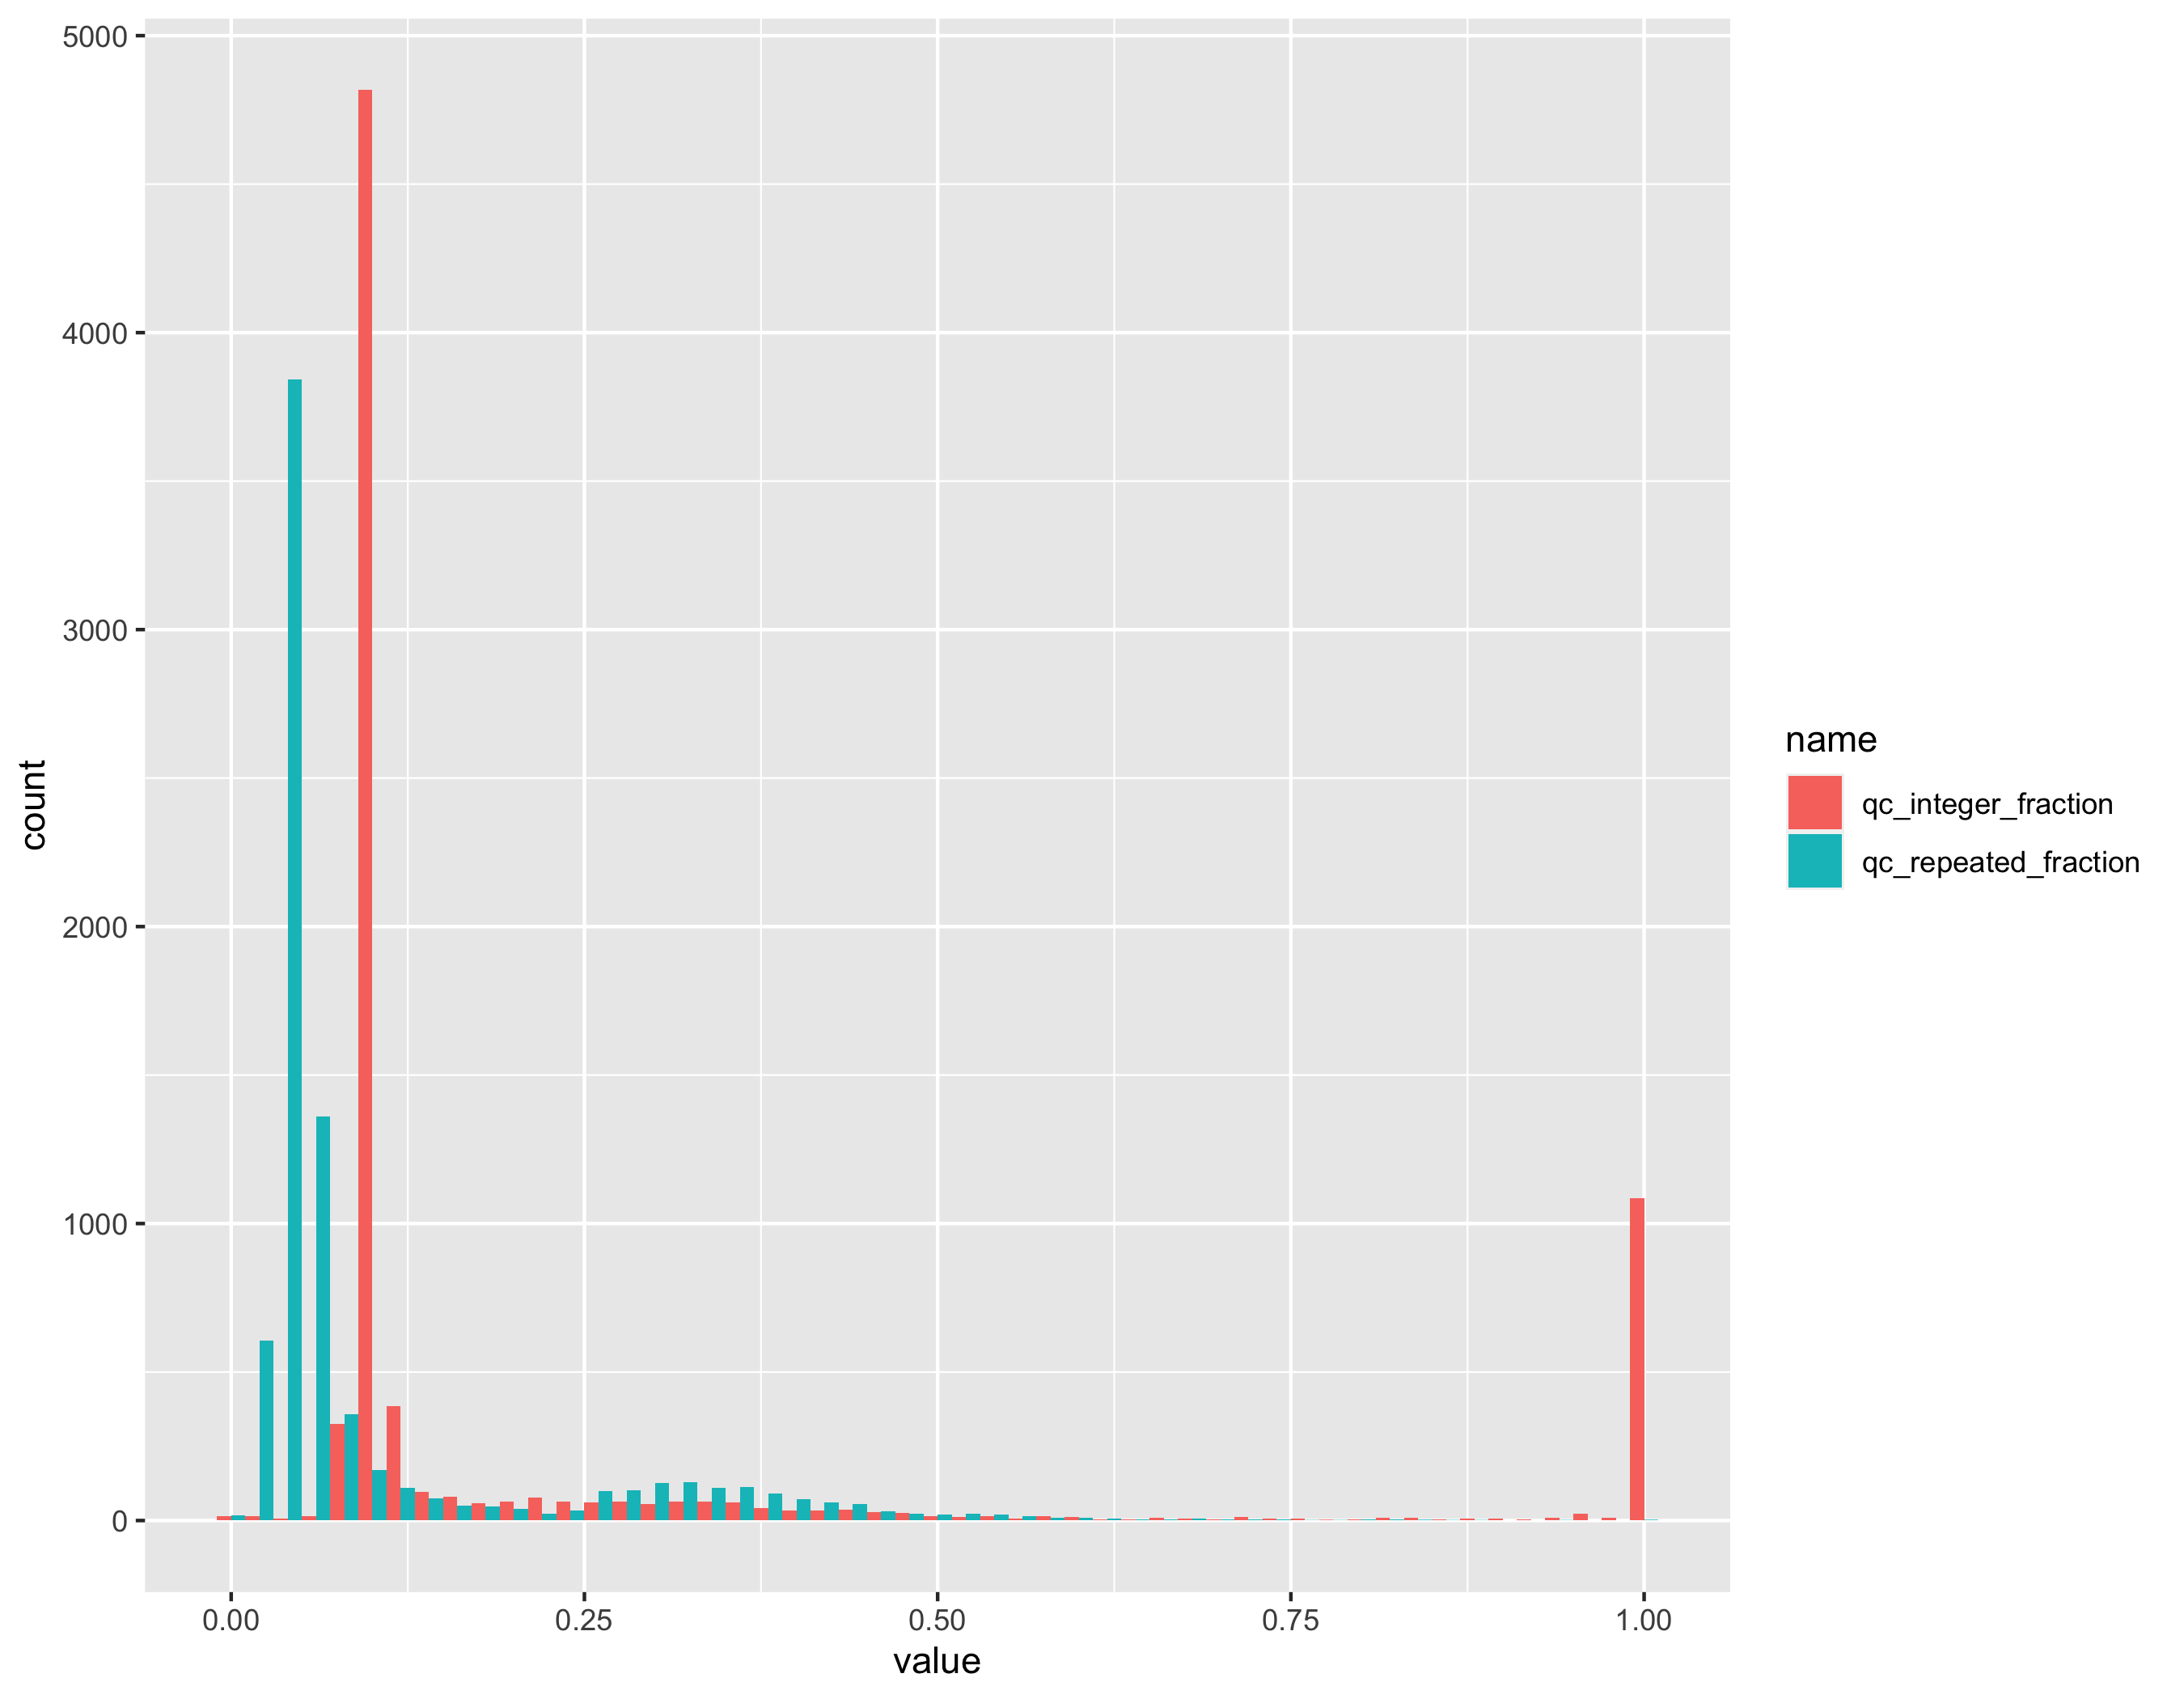

In [82]:
ggplot(series_table.insights |> pivot_longer(c(qc_repeated_fraction, qc_integer_fraction))) +
    geom_histogram(aes(value, fill = name), binwidth = 0.02, position = "dodge")


Vanno eliminate? Step successivi del QC li farò tutti insieme

In [93]:
series_meta <- ser_stat_tab |> left_join(stations_table)
work_series <- series_meta |>
    filter(lat > 42, state %in% c("Valle D'Aosta", "Lombardia", "Liguria", "Piemonte", "Trentino-Alto Adige", "Friuli-Venezia Giulia", "Emilia-Romagna", "Toscana", "Marche", "Umbria") | is.na(state), last_date >= "2005-01-01") |>
    st_md_to_sf() |>
    select(series_id, variable, station_name, network, state, elevation, last_date)

scia_data <- data |>
    inner_join(ser_stat_tab, by = "series_id") |>
    select(-merged)


Joining with `by = join_by(station_id, original_id)`


## Analisi disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese

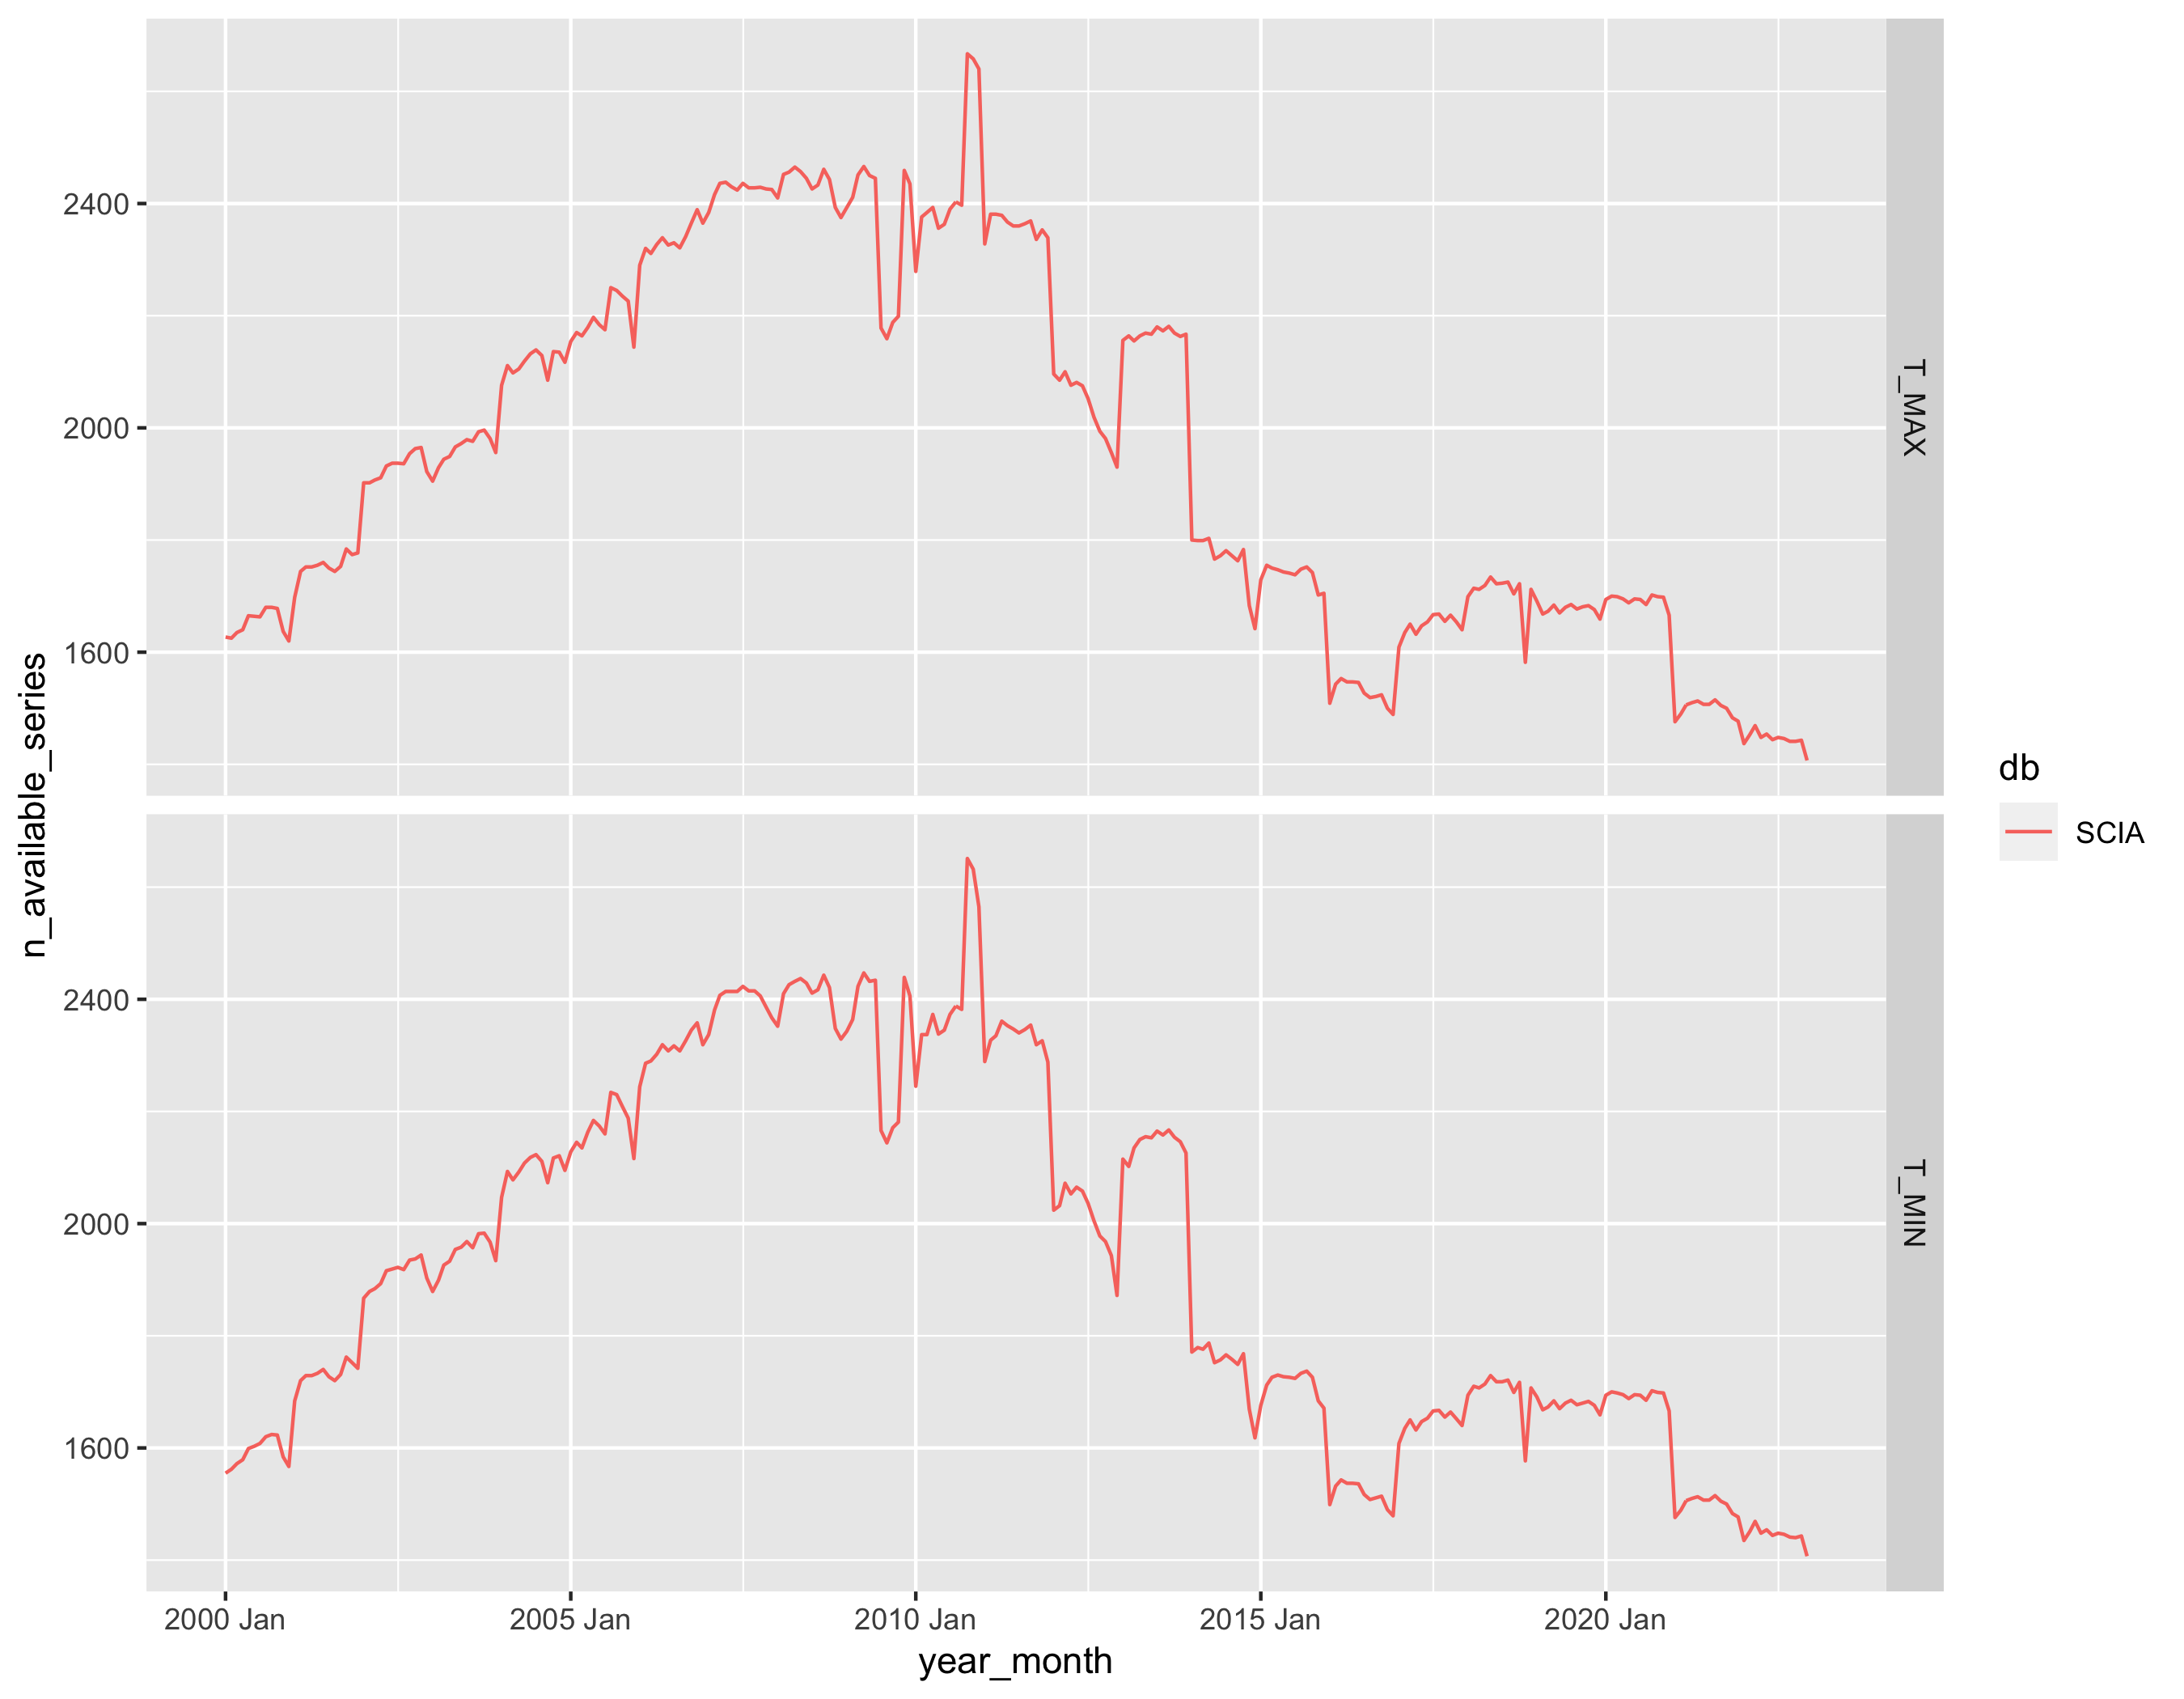

In [64]:
# scia_data |>
#     rename(identifier = series_id) |>
#     mutate(db = dataset_id) |>
#     plot_state_avail(first_date, last_date)


In [ ]:
ita_boundaries <- load.italian_boundaries("state")
# climats_comp <- is_climatology_computable(as_tsibble(scia_data, key = c(identifier, variable), index = date), value, .start = first_date, .end = last_date) |>
#     left_join(stations_table |> select(station_id, lon, lat) |> collect(), by = join_by(identifier == station_id)) |>
#     st_md_to_sf()
